In [7]:
### libraries...
### python libraries

import os, sys

### setting the working directory in ~/RNAnet/
os.chdir(".")

#### set the maximum number of process to be used (in this case 4)
os.environ["MKL_NUM_THREADS"] = "4" 
os.environ["NUMEXPR_NUM_THREADS"] = "4" 
os.environ["OMP_NUM_THREADS"] = "4" 

import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as mpl
import random as rm
import glob



### home-made libraries
print(os.getcwd())
sys.path.append("Functions/")
import Network_functions as NF
import Susceptibility_functions as SF
import Observables_functions as OF
import Structure_functions as STF

/home/mattia/RNAnet


In [21]:
PLOT = 0
N_ARG = 7

ER_ON = 1
REAL_ON = 1

def  requested_argv():
    print("\nError! Wrong number of argument.\n")
    print("python Cv_analyser.py net_file  param_file label N_rip savedir")
    print("- net_file, file where original network is stored;")
    print("- param_file, file where simulation parameters are stored;")
    print("- label, an identification for the output;")
    print("- savedir, directory where to save networks.")
    print("- Tr, Cv of mirnas and cernas m0, and mu0.")
    print("- Bd, 0, 1, 2 to regulate binding heterogs.")
    print("\n")


    
       
net_file = "toy_net.txt"
param_file = "Files/parameterFile_toymodel.txt"
Lab = "toy_net"   
savedir = "."

TH = 0.4 
BH = 2
    
os.system("mkdir %s"%savedir)

### reading options (parameters) from file
Opt = NF.Options(param_file)        

Opt.Bd = BH
Opt.Cv_beta = TH
Opt.Cv_b = TH

N_step = int(Opt.N_step)
N_rip = int(Opt.N_rip)
        
####################################
### Reading df_links...
#
# gene_m,mir_n,weigth
#
# 0 1 1
# 0 2 1
# 1 1 1
# - - -
#
########################

links =  NF.LinksFunc(net_file, Opt.m0, Opt.Bd)
   
    
#### checking number of of rows and columns...
sys.stderr.write("links--> %d, %d\n"%(np.shape(links)))
if(np.shape(links)[1] !=3):
    sys.stderr.write("Error! Links file has more that three columns!\n")
    exit()


    
### computing number of mirna and cernas...
M, N = NF.SpeciesNumbers(links) 

print("The network is composed by:")
print("N = %d miRNA molecules"%N)
print("M = %d ceRNA molecules"%M)

('links-->', (12, 3))
Real heterogeneity
The network is composed by:
N = 6 miRNA molecules
M = 4 ceRNA molecules


links--> 12, 3


In [22]:
### initializing beta vector.. the control parameter variation
beta_vet = np.logspace(np.log(Opt.betaMin), np.log(Opt.betaMax), N_step, base= np.e)
 
m_res = np.zeros((N_step, M))
n_res = np.zeros((N_step, N))

for i in range(N_step):
    beta = beta_vet[i]
    for j in range(N_rip):
        #### computing m* and n* vet...
        m_ = NF.SampleDistFunc(Opt.meanb, Opt.Cv_b*Opt.meanb,  "lognorm", M)/float(Opt.d)
        n_ = NF.SampleDistFunc( beta, Opt.Cv_beta*beta, "lognorm", N)/float(Opt.delta)
    
        ### computing mirna and cerna concetrations...
        n, m = NF.ConcFinder(Links=links, vet_star_m= m_, vet_star_n= n_, lam= Opt.lam)
        
        m_res[i,:] += m
        n_res[i,:] += n
m_res /= N_rip
n_res /= N_rip


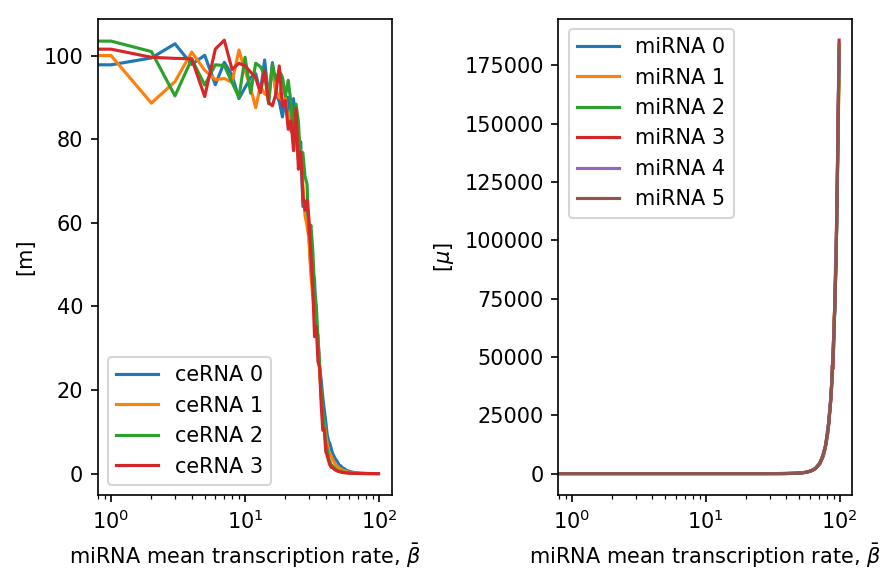

In [23]:
fig, ax = mpl.subplots(1,2, dpi= 150)

##plotting cerna free concentrations
for i in range(M):
    ax[0].plot(m_res[:,i], label = "ceRNA %d"%i)
for i in range(N):
    ax[1].plot(n_res[:,i], label = "miRNA %d"%i)
ax[0].legend()
ax[1].legend()
ax[0].set_xscale("log")
ax[1].set_xscale("log")

ax[0].set_xlabel("miRNA mean transcription rate, $\\bar{\\beta}$")
ax[1].set_xlabel("miRNA mean transcription rate, $\\bar{\\beta}$")

ax[0].set_ylabel("[m]")
ax[1].set_ylabel("[$\\mu$]")


mpl.tight_layout()

In [24]:
### intializing res matrix... 
Obs = np.zeros((N_step, 9))
Obs[:,0] = beta_vet


for i in range(N_step):
    
    sys.stderr.write("\rProgress %d %%"%(i*100./N_step))
    sys.stderr.flush()
    
    beta = beta_vet[i]
    for j in range(N_rip):
        #### computing m* and n* vet...
        m_ = NF.SampleDistFunc(Opt.meanb, Opt.Cv_b*Opt.meanb,  "lognorm", M)/float(Opt.d)
        n_ = NF.SampleDistFunc( beta, Opt.Cv_beta*beta, "lognorm", N)/float(Opt.delta)
    
        ### computing mirna and cerna concetrations...
        n, m = NF.ConcFinder(Links=links, vet_star_m= m_, vet_star_n= n_, lam= Opt.lam)
        
        ### computing susceptibility and inverse binding weigth proxy...
        X_ij, K_ij = SF.X_K_ij_func(links, n,m, n_,m_, Opt.lam, 1)

        mm, nn, m_norm, n_norm = OF.Obs_conc_func(m, n, m_, n_)
        Xmean, Xmax = OF.Obs_X_MeanMax_func(X_ij)
        Delta = OF.Obs_X_Delta_func(X_ij)
        rho = OF.Obs_X_rho_func(X_ij, K_ij)
        Sin, Sout = OF.Obs_Sel_func(X_ij)

        Obs[i,1:] += m_norm, n_norm, Xmean, Xmax, Delta, rho, Sin, Sout

Obs[:,1:] /= N_rip

Progress 99 %

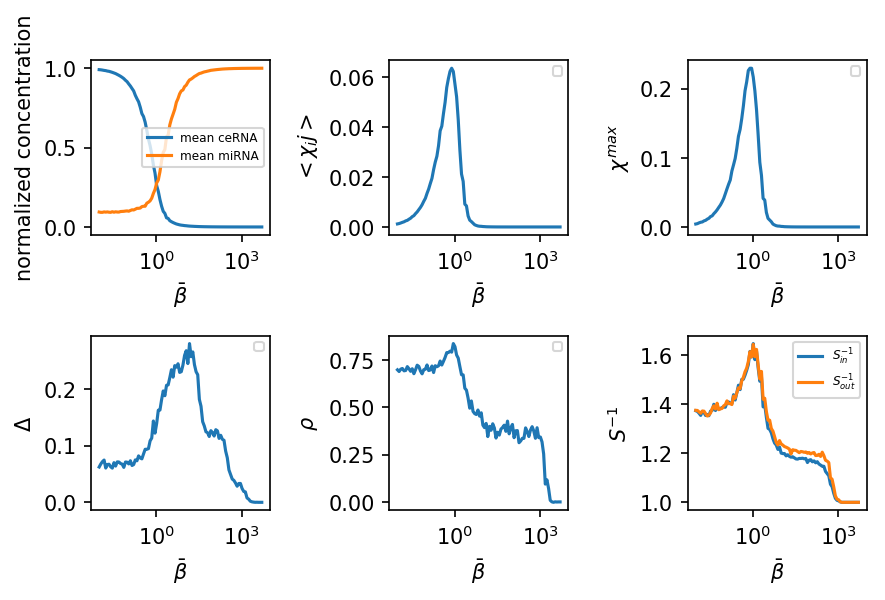

In [27]:
fig, ax = mpl.subplots(2,3, dpi= 150)

##plotting observables
ax[0,0].plot(Obs[:,0], Obs[:,1],label = "mean ceRNA")
ax[0,0].plot(Obs[:,0], Obs[:,2],label = "mean miRNA")

ax[0,1].plot(Obs[:,0], Obs[:,3])
ax[0,2].plot(Obs[:,0], Obs[:,4])
ax[1,0].plot(Obs[:,0], Obs[:,5])
ax[1,1].plot(Obs[:,0], Obs[:,6])
ax[1,2].plot(Obs[:,0], 1./Obs[:,7], label = "$S_{in}^{-1}$")
ax[1,2].plot(Obs[:,0], 1./Obs[:,8], label = "$S_{out}^{-1}$")



for i in range(2):
    for j in range(3):
        ax[i,j].legend(fontsize="xx-small")
        ax[i,j].set_xscale("log")
        ax[i,j].set_xlabel("$\\bar{\\beta}$")

ax[0,0].set_ylabel("normalized concentration")
ax[0,1].set_ylabel("$<\\chi_ij>$")
ax[0,2].set_ylabel("$\\chi^{max}$")
ax[1,0].set_ylabel("$\\Delta$")
ax[1,1].set_ylabel("$\\rho$")
ax[1,2].set_ylabel("$S^{-1}$")


mpl.tight_layout()